In [1]:
import torch
# import tenseal as ts
import pandas as pd
import time

from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import pickle
import seaborn as sns
from openfhe import *
from tqdm import tqdm
import openfhe
from openfhe import PKESchemeFeature

Setul de date este luat din kaggle: https://www.kaggle.com/datasets/mahatiratusher/stroke-risk-prediction-dataset-v2/data si este procesat in notebook-ul data/process_data.ipynb pentru usurinta.

Codul se poate rula integral prin optiunea "Run All" a notebook-ului

In [2]:
def load_data(path):
    saved_data = torch.load(path,weights_only=True)
    x_train = saved_data['train_data']
    x_test = saved_data['test_data']
    y_train = saved_data['train_labels']
    y_test = saved_data['test_labels']
    print("############# Data summary #############")
    print(f"x_train has shape: {x_train.shape}")
    print(f"y_train has shape: {y_train.shape}")
    print(f"x_test has shape: {x_test.shape}")
    print(f"y_test has shape: {y_test.shape}")
    print("#######################################")
    return x_train,x_test,y_train,y_test

In [3]:
def normalize_data(x_train,x_test,y_train,y_test):
    scaler = StandardScaler()
    x_train = torch.tensor(scaler.fit_transform(x_train), dtype=torch.float32)
    x_test= torch.tensor(scaler.transform(x_test), dtype=torch.float32)
    print(x_train.shape)
    print(x_test.shape)
    y_train = torch.tensor(scaler.fit_transform(y_train), dtype=torch.float32)
    y_test = torch.tensor(scaler.transform(y_test), dtype=torch.float32)
    return x_train,x_test,y_train,y_test


In [4]:
x_train,x_test,y_train,y_test = load_data('../../data/date_liniar_regression.pth')
x_train,x_test,y_train,y_test = normalize_data(x_train,x_test,y_train,y_test)



############# Data summary #############
x_train has shape: torch.Size([24500, 16])
y_train has shape: torch.Size([24500, 1])
x_test has shape: torch.Size([10500, 16])
y_test has shape: torch.Size([10500, 1])
#######################################
torch.Size([24500, 16])
torch.Size([10500, 16])


In [ ]:
class LinearRegressionEncrypted:
    def __init__(self, n_features, learning_rate=1e-2, weight_decay=0.01):
        self.bound = np.sqrt(3/n_features)
        self.weight = [0.01] * n_features
        # self.weight = np.random.uniform(-self.bound, self.bound, size=n_features).tolist()
        self.bias = np.zeros(n_features).tolist()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self._delta_w = 0
        self._delta_b = 0


    def forward_on_encrypted_data(self, enc_x):
        output = []
        for x in enc_x:
            enc_sum = cc.EvalInnerProduct(x, self.weight,16)
            enc_pred = cc.EvalAdd(enc_sum, self.bias)
            output.append(enc_pred)
        return output

   
    def backward(self, enc_x, enc_out, enc_y):
        batch_size = len(enc_x)
        half = 2/batch_size
        delta_y = [cc.EvalSub(out , y) for out, y in zip(enc_out, enc_y)]
        delta_w = [cc.EvalMultAndRelinearize(x , dy) for dy, x in zip(delta_y, enc_x)]
        self._delta_w = cc.EvalAddManyInPlace(delta_w)
        self._delta_w = cc.EvalMult(self._delta_w, half)
        self._delta_b = cc.EvalAddManyInPlace(delta_y)
        self._delta_b = cc.EvalMult(self._delta_b, half)
       

    def update_parameters(self):
        if self._delta_w == 0:
            raise RuntimeError("Trebuie sa treci prin functia forword macar o data")
        self._delta_w = cc.EvalMult(self._delta_w, self.learning_rate)
        prod = cc.EvalMult(self.weight_decay,  self.weight)
        self._delta_w = cc.EvalAdd(self._delta_w, prod) 
        self.weight = cc.EvalSub(self.weight, self._delta_w)
        prod = cc.EvalMult(self._delta_b, self.learning_rate)
        self.bias = cc.EvalSub(self.bias,prod) 

        decr_w= cc.Decrypt(self.weight, keys.secretKey)
        decr_w = decr_w.GetRealPackedValue()
        decr_b = cc.Decrypt(self.bias, keys.secretKey)
        decr_b = decr_b.GetRealPackedValue()
    
        self._delta_w = 0
        self._delta_b = 0
    
#intr-un scenariu real functiile de decriptare ar sta la client
    def encrypt(self):
        self.weight = cc.MakeCKKSPackedPlaintext(self.weight)
        self.weight = cc.Encrypt(keys.publicKey, self.weight )
        self.bias = cc.MakeCKKSPackedPlaintext(self.bias)
        self.bias= cc.Encrypt(keys.publicKey, self.bias)
       
    def decrypt(self):
        self.weight = cc.Decrypt(self.weight, keys.secretKey)
        self.weight = self.weight.GetRealPackedValue()
        self.bias = cc.Decrypt(self.bias, keys.secretKey)
        self.bias = self.bias.GetRealPackedValue()
      
       

In [ ]:
multDepth = 8
scaleModSize = 50
batchSize = len(x_test[1]) #16
parameters = openfhe.CCParamsCKKSRNS()
parameters.SetMultiplicativeDepth(multDepth)
parameters.SetScalingModSize(scaleModSize)
parameters.SetBatchSize(batchSize)
# parameters.SetScalingTechnique(openfhe.ScalingTechnique.FLEXIBLEAUTO)
parameters.SetFirstModSize(60)

#pentru rapididate este bine sa se inceapa fara un nivel de securitate prea mare
parameters.SetRingDim(4096)
parameters.SetSecurityLevel(openfhe.HEStd_NotSet)

#daca nu setam de mana dimensiunea inelului o sa o setet biblioteca in functie de parametrii dati
# parameters.SetSecurityLevel(openfhe.HEStd_128_classic)

cc = openfhe.GenCryptoContext(parameters)

cc.Enable(PKESchemeFeature.PKE)
cc.Enable(PKESchemeFeature.KEYSWITCH)
cc.Enable(PKESchemeFeature.LEVELEDSHE)
cc.Enable(PKESchemeFeature.ADVANCEDSHE)
cc.Enable(PKESchemeFeature.FHE)
ring_dim = cc.GetRingDimension()
security_param= parameters.GetSecurityLevel()

#intr-un scenariu real cheile secrete ar sta la client
keys = cc.KeyGen()

cc.EvalMultKeyGen(keys.secretKey)
cc.EvalSumKeyGen(keys.secretKey)

print(f"ring dim: {cc.GetRingDimension()}")



ring dim: 4096


In [ ]:
#libraria openfhe lucreaza cu doar cu liste, datele mele sunt torch tensors, deci trebuie convertite
print(x_train.shape)
x_train_list = x_train[:1000].tolist() 
print(x_train_list[:2])
print(type(x_train_list[0]))

print(y_train.shape)
y_train_list = y_train[:1000].tolist() 
print(y_train_list[:2])
print(type(y_train_list[0]))


print(x_test.shape)
x_test_list = x_test[:700].tolist() 
print(x_test_list[:2])
print(type(x_test_list[0]))


torch.Size([24500, 16])
[[0.38178399205207825, 0.9948703050613403, -0.4117799401283264, -0.5782929062843323, -0.3283218741416931, -0.48778727650642395, -0.5707517862319946, -0.4851568639278412, -0.41272860765457153, -0.3342396318912506, -0.3290841579437256, -0.343669593334198, -0.4097440242767334, 2.0449681282043457, -0.4168514609336853, -0.33037757873535156], [0.38178399205207825, 0.9948703050613403, -0.4117799401283264, -0.5782929062843323, 3.0457913875579834, -0.48778727650642395, 1.7520751953125, 2.0611891746520996, -0.41272860765457153, -0.3342396318912506, -0.3290841579437256, -0.343669593334198, 2.4405479431152344, -0.4890051484107971, 2.3989360332489014, -0.33037757873535156]]
<class 'list'>
torch.Size([24500, 1])
[[-0.6384840607643127], [1.2037829160690308]]
<class 'list'>
torch.Size([10500, 16])
[[-0.4856494069099426, -1.00515615940094, -0.4117799401283264, 1.7292275428771973, -0.3283218741416931, -0.48778727650642395, -0.5707517862319946, -0.4851568639278412, -0.412728607654

In [8]:
def encrypt_vector(lista):
    enc_list=[]
    for x_t_l in tqdm(lista, desc="data encryption"):
        x_test_encoded = cc.MakeCKKSPackedPlaintext(x_t_l)
        enc_x_test = cc.Encrypt(keys.publicKey, x_test_encoded)
        enc_list.append(enc_x_test)
    return enc_list

In [9]:
t_start = time.perf_counter()
enc_x_train = encrypt_vector(x_train_list)
t_end = time.perf_counter()
print(f"encryption took: {t_end-t_start}")

data encryption: 100%|██████████| 1000/1000 [00:07<00:00, 134.12it/s]

encryption took: 7.4640516129998105


In [10]:
t_start = time.perf_counter()
enc_x_test = encrypt_vector(x_test_list)
t_end = time.perf_counter()
print(f"encryption took: {t_end-t_start}")

data encryption:   0%|          | 0/700 [00:00<?, ?it/s]

data encryption: 100%|██████████| 700/700 [00:05<00:00, 124.85it/s]

encryption took: 5.619526210000004


In [13]:
#etichetele fiind vectori de dimensiune 1 trebuie facut broadcast la valoarea de pe pozitia 0, marind vectorul
#la unul de dimensiune 16, deoarce biblioteca lucreza cu vectori de dimenesniuni : batchSize = len(x_test[1]) #16
def encrypt_vector_y(lista):
    enc_list=[]
    for x_t_l in tqdm(lista, desc="data encryption"):
        x_test_encoded = cc.MakeCKKSPackedPlaintext(x_t_l*16)
        enc_x_test = cc.Encrypt(keys.publicKey, x_test_encoded)
        enc_list.append(enc_x_test)
    return enc_list

In [14]:
t_start = time.perf_counter()
enc_y_train = encrypt_vector_y(y_train_list)
t_end = time.perf_counter()
print(f"encryption took: {t_end-t_start}")

data encryption: 100%|██████████| 1000/1000 [00:08<00:00, 124.66it/s]

encryption took: 8.040943523000351


In [15]:
print(cc.Decrypt(enc_y_train[0],keys.secretKey))
#se vede aici ce fel de vector trebuie sa avem pentru etichete

(-0.638484, -0.638484, -0.638484, -0.638484, -0.638484, -0.638484, -0.638484, -0.638484, -0.638484, -0.638484, -0.638484, -0.638484, -0.638484, -0.638484, -0.638484, -0.638484,  ... ); Estimated precision: 44 bits



In [13]:
def save_model(model,file_path):
    pickle.dump(model, open(file_path, "wb"))


In [19]:
def forward_test(model, x_test):
    w = torch.tensor(model.weight)
    b = torch.tensor(model.bias)
    out = (x_test.matmul(w) + b[0]).reshape(-1, 1)
    return out

In [20]:
y = y_test[:700].detach().numpy()

In [22]:
model = LinearRegressionEncrypted(x_train.shape[1])

In [24]:
model = LinearRegressionEncrypted(x_train.shape[1])
batch_size = 512
t_start = time.perf_counter()
for epoch in tqdm(range(20),desc="epoch"):
    t_start_epoch = time.perf_counter()
    indices = np.random.permutation(len(enc_x_train))
    epoch_data = [enc_x_train[idx] for idx in indices]
    epoch_targets = [enc_y_train[idx] for idx in indices]


    for batch in range(0, len(epoch_data),batch_size):
        #deoarce weight-urile si bias-ul acumuleaza mult noise avem 2 optiuni:
        #-bootstraping (extrem de greoi)
        #sa criptam si decryptam weight-urile 
        model.encrypt()
        batch_data = epoch_data[batch: batch+batch_size]
        batch_targets = epoch_targets[batch: batch+batch_size]

        batch_out = model.forward_on_encrypted_data(batch_data)
        model.backward(batch_data, batch_out, batch_targets)
        model.update_parameters()
        model.decrypt()
    
    pred = forward_test(model,x_test[:700])
    t_end = time.perf_counter()

    pred = pred.detach().numpy()
    r2 = r2_score(y, pred)
    print(f"R^2 Score = {r2:.4f}")
    mse =  mean_squared_error(y, pred)
    print(f"MSE = {mse:.4f}")
t_end = time.perf_counter()
print(f"Antrenarea modelului pe date criptate a durat: {t_end-t_start} secunde")
# save_model(model,'li_r_trained_on_clear_data.pkl')


epoch:   5%|▌         | 1/20 [01:15<24:03, 75.96s/it]

R^2 Score = 0.2123
MSE = 0.8141


epoch:  10%|█         | 2/20 [02:31<22:43, 75.75s/it]

R^2 Score = 0.3172
MSE = 0.7057


epoch:  15%|█▌        | 3/20 [03:58<22:51, 80.65s/it]

R^2 Score = 0.4051
MSE = 0.6149


epoch:  20%|██        | 4/20 [05:14<21:01, 78.81s/it]

R^2 Score = 0.4789
MSE = 0.5386


epoch:  25%|██▌       | 5/20 [06:24<18:58, 75.93s/it]

R^2 Score = 0.5411
MSE = 0.4743


epoch:  30%|███       | 6/20 [07:36<17:22, 74.49s/it]

R^2 Score = 0.5935
MSE = 0.4202


epoch:  35%|███▌      | 7/20 [08:47<15:52, 73.26s/it]

R^2 Score = 0.6378
MSE = 0.3743


epoch:  40%|████      | 8/20 [09:49<13:57, 69.75s/it]

R^2 Score = 0.6754
MSE = 0.3355


epoch:  45%|████▌     | 9/20 [10:57<12:40, 69.16s/it]

R^2 Score = 0.7074
MSE = 0.3024


epoch:  50%|█████     | 10/20 [12:04<11:25, 68.58s/it]

R^2 Score = 0.7346
MSE = 0.2743


epoch:  55%|█████▌    | 11/20 [13:12<10:14, 68.26s/it]

R^2 Score = 0.7578
MSE = 0.2503


epoch:  60%|██████    | 12/20 [14:10<08:42, 65.32s/it]

R^2 Score = 0.7776
MSE = 0.2298


epoch:  65%|██████▌   | 13/20 [15:10<07:25, 63.66s/it]

R^2 Score = 0.7946
MSE = 0.2123


epoch:  70%|███████   | 14/20 [16:08<06:11, 61.84s/it]

R^2 Score = 0.8092
MSE = 0.1972


epoch:  75%|███████▌  | 15/20 [17:05<05:02, 60.46s/it]

R^2 Score = 0.8218
MSE = 0.1841


epoch:  80%|████████  | 16/20 [18:03<03:58, 59.66s/it]

R^2 Score = 0.8327
MSE = 0.1729


epoch:  85%|████████▌ | 17/20 [19:00<02:56, 58.93s/it]

R^2 Score = 0.8422
MSE = 0.1631


epoch:  90%|█████████ | 18/20 [19:57<01:56, 58.23s/it]

R^2 Score = 0.8504
MSE = 0.1546


epoch:  95%|█████████▌| 19/20 [20:55<00:58, 58.23s/it]

R^2 Score = 0.8576
MSE = 0.1472


epoch: 100%|██████████| 20/20 [21:55<00:00, 65.76s/it]

R^2 Score = 0.8639
MSE = 0.1407
Antrenarea modelului pe date criptate a durat: 1315.2043107519994 secunde


In [25]:
def metrics_on_clear_data(model, x, y):
    t_start = time.perf_counter()
    pred = forward_test(model,x)
    t_end = time.perf_counter()
    print(f"Predictiile pe testul de date necriptate au durat:{(t_end - t_start):.20f} secunde")

    r2 = r2_score(y, pred)
    print(f"R^2 Score = {r2:.4f}")
    mse =  mean_squared_error(y, pred)
    print(f"MSE = {mse:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(y, pred, alpha=0.5, color='darkred', label='Predicții vs. Valori Reale')
    plt.plot([min(y), max(y)], [min(y), max(y)], color='blue', linestyle='--', label='Predicții perfecte')
    plt.xlabel('Valori Reale', fontsize=12)
    plt.ylabel('Predicții', fontsize=12)
    plt.title('Model antrenat pe date criptate-Preziceri pe date clare', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title=f'$R^2 = {r2:.4f}$\nMSE = {mse:.4f}', title_fontsize=12)
    plt.savefig("../../plots/liniar_regression/li_r_trained_on_encrypted_data_predictions_on_clear_data.png")
    plt.show()
    return r2,mse

Predictiile pe testul de date necriptate au durat:0.00110811800004739780 secunde
R^2 Score = 0.8546
MSE = 0.1539


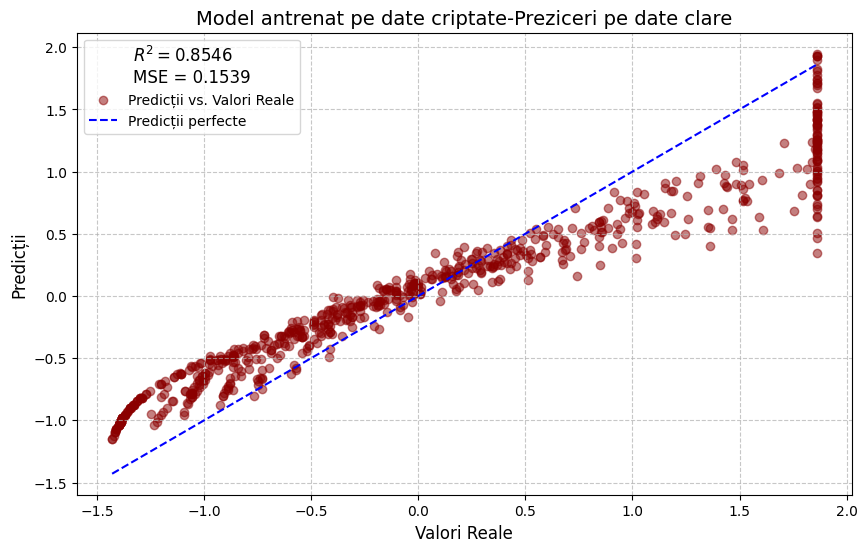

In [26]:
r2_clear,mse= metrics_on_clear_data(model,x_train[:700], y_train[:700])

In [30]:
def feature_importance(model, feature_names):
    weights = model.weight
    print(weights)

    weights = np.abs(weights)
    weights = weights / np.sum(weights)

    sorted_indices = np.argsort(weights)
    feature_names_sorted = [feature_names[i] for i in sorted_indices]
    weights_sorted = weights[sorted_indices]

    plt.figure(figsize=(16, 6))
    sns.barplot(y=feature_names_sorted, x=weights_sorted, hue=feature_names_sorted, palette="Reds", orient="h", legend=False)

    plt.xlabel('Importanța caracteristicilor', fontsize=12)
    plt.ylabel('Caracteristici', fontsize=12)
    plt.title('Grafic de importanța caracteristicilor- model antrenat pe date criptate', fontsize=14)

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig("../../plots/liniar_regression/li_r_trained_on_encrypted_data_feature_importance.png")
    plt.show()



['Age', 'Gender', 'Chest Pain', 'High Blood Pressure', 'Irregular Heartbeat', 'Shortness Of Breath', 'Fatigue Weakness', 'Dizziness', 'Swelling Edema', 'Neck Jaw Pain', 'Excessive Sweating', 'Persistent Cough', 'Chest Discomfort', 'Cold Hands Feet', 'Snoring Sleep Apnea', 'Anxiety Doom']
[0.31887244531384434, -0.05582897310738062, 0.1321659264457987, 0.18001451942957486, 0.10064905576143093, 0.10749381096144932, 0.1000941641169159, 0.10024774040709103, 0.07531031919693837, 0.08992965325571313, 0.05024474620600338, 0.06729939423147836, 0.101231212394162, 0.07735809967244091, 0.11570921977243101, 0.042290060141332714]


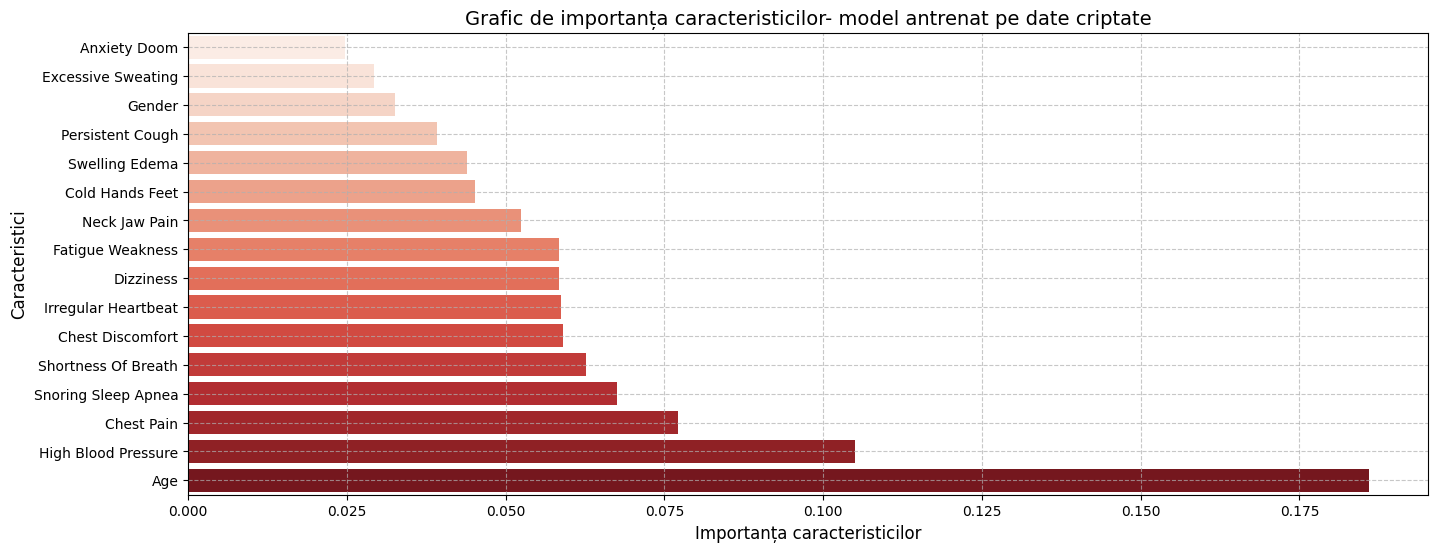

In [31]:
csv = pd.read_csv('../../data/stroke_risk_dataset.csv')
csv = csv.drop(columns=["stroke_risk_percentage", "at_risk", "nausea_vomiting"])
header = csv.columns.tolist()

formatted_features = [feat.replace('_', ' ').title() for feat in header]
print(formatted_features)
feature_importance(model,formatted_features) 

In [32]:
def metrics_on_encrypted_data(model, enc_x, y):
    #predictiile sunt se vor intoarce criptate
    t_start = time.perf_counter()
    model.encrypt()
    enc_list_pred = model.forward_on_encrypted_data(enc_x)
    model.decrypt()
    t_end = time.perf_counter()
    print(f"Predictiile pe testul de date criptat au durat:{(t_end - t_start):.20f} secunde")
    # return enc_list_pred[0]
    #trebuie decriptate pentru a calcula metricile
    list_pred = []
    t_start = time.perf_counter()
    for enc_pred in enc_list_pred:
        decript = cc.Decrypt(enc_pred, keys.secretKey)
        decript.SetLength(1)
        decoded_values = decript.GetCKKSPackedValue()
        list_pred.append(decoded_values[0].real)
    t_end = time.perf_counter()
    print(f"Decriptarea predictiilor a durat:{(t_end - t_start):.20f} secunde")
    
    print(list_pred[0])
    print(list_pred[0].real)
    # list_pred = [x.real for x in list_pred]
    print(list_pred[0])
    y = y.detach().numpy()
    r2 = r2_score(y, list_pred)
    print(f"R^2 Score = {r2:.4f}")
    mse =  mean_squared_error(y, list_pred)
    print(f"MSE = {mse:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(y, list_pred, alpha=0.5, color='darkred', label='Predictii vs. Valori Reale')
    plt.plot([min(y), max(y)], [min(y), max(y)], color='blue', linestyle='--', label='Predictii perfecte')
    plt.xlabel('Valori Reale', fontsize=12)
    plt.ylabel('Predictii', fontsize=12)
    plt.legend(title=f'$R^2 = {r2:.4f}$\nMSE = {mse:.4f}', title_fontsize=12)
    plt.title('Model antrenat pe date criptate-Preziceri pe date criptate', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig("../../plots/liniar_regression/li_r_trained_on_encrypted_data_predictions_on_encrypted_data.png")
    plt.show()
    return r2

Predictiile pe testul de date criptat au durat:40.45456264299900794867 secunde
Decriptarea predictiilor a durat:4.24282112800028698985 secunde
0.19434662114560938
0.19434662114560938
0.19434662114560938
R^2 Score = 0.8639
MSE = 0.1407


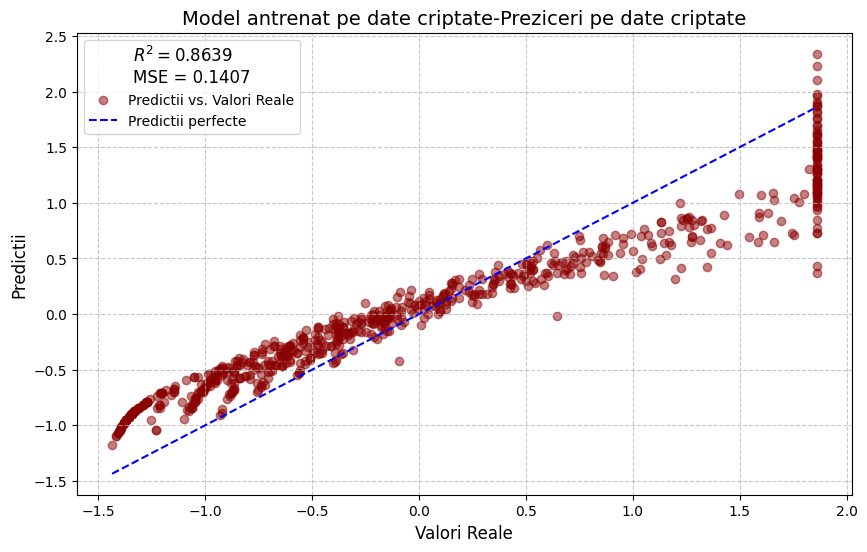

In [33]:
r2_enc = metrics_on_encrypted_data(model,enc_x_test,y_test[:700])